In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('max_colwidth', None)

In [3]:
sbi = pd.read_csv("SBIN.csv")
hdfc = pd.read_csv("HDFCN.csv")


In [4]:
sbi = sbi[['Date',"Close",'Open']]
hdfc = hdfc[['Date',"Close",'Open']]

In [5]:
sbi['Date'] = pd.to_datetime(sbi.Date,dayfirst=True)
sbi.set_index("Date" , inplace = True)
sbi = sbi.asfreq('b')
sbi.head()

,Close,Open
Date,,
2021-07-09,423.750000,425.000000
2021-07-12,427.450012,426.500000
2021-07-13,429.100006,430.000000
2021-07-14,431.049988,429.000000
2021-07-15,431.700012,432.700012


In [6]:
hdfc['Date'] = pd.to_datetime(hdfc.Date,dayfirst=True)
hdfc.set_index("Date" , inplace = True)
hdfc = hdfc.asfreq('b')
hdfc.head()

,Close,Open
Date,,
2021-07-09,1502.000000,1512.550049
2021-07-12,1487.000000,1502.000000
2021-07-13,1501.849976,1496.099976
2021-07-14,1499.150024,1497.500000
2021-07-15,1520.699951,1505.000000


In [7]:
#Can not split randomly as we have to predict the latest values
'''from sklearn.model_selection import train_test_split
X= sbi
y= sbi
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size = 0.1)'''

'from sklearn.model_selection import train_test_split\nX= sbi\ny= sbi\nX_train,X_test,y_train, y_test = train_test_split(X,y,test_size = 0.1)'

# Dividing dataset into training and testing data

In [8]:
train_sbi = sbi.iloc[:int(sbi.shape[0]*0.9), :]
test_sbi = sbi.iloc[int(sbi.shape[0]*0.9):, :]

In [9]:
sbi.isna().sum()

Close    12
Open     12
dtype: int64

In [10]:
sbi.Close = sbi.Close.fillna(method = 'bfill')
sbi.Open = sbi.Open.fillna(method = "bfill")

In [11]:
sbi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2021-07-09 to 2022-07-08
Freq: B
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   261 non-null    float64
 1   Open    261 non-null    float64
dtypes: float64(2)
memory usage: 6.1 KB


In [12]:
train_sbi.shape, test_sbi.shape

((234, 2), (27, 2))

In [13]:
train_hdfc = hdfc.iloc[:int(hdfc.shape[0]*0.9), :]
test_hdfc = hdfc.iloc[int(hdfc.shape[0]*0.9):, :]

In [14]:
hdfc.Close = hdfc.Close.fillna(method = "ffill")
hdfc.Open = hdfc.Open.fillna(method = "ffill")

In [15]:
train_hdfc.shape, test_hdfc.shape

((234, 2), (27, 2))

# Dickey Fuller test

In [16]:
from statsmodels.tsa.stattools import adfuller

#H0: It is not stationary
#H1: It is stationary
def dickey_fuller_test(timeseries, window = 12, cutoff = 0.01):
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
dickey_fuller_test(sbi['Close'])

p-value = 0.1693. The series is likely non-stationary.
Test Statistic                  -2.308175
p-value                          0.169345
#Lags Used                       0.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


In [17]:
first_diff = sbi['Close']-sbi['Close'].shift(1)
first_diff = first_diff.dropna(inplace = False)
sbi['First difference'] = first_diff
sbi.head()

,Close,Open,First difference
Date,,,
2021-07-09,423.750000,425.000000,NaN
2021-07-12,427.450012,426.500000,3.700012
2021-07-13,429.100006,430.000000,1.649994
2021-07-14,431.049988,429.000000,1.949982
2021-07-15,431.700012,432.700012,0.650024


In [18]:
dickey_fuller_test(first_diff)

p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.255132e+01
p-value                        2.202763e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.580000e+02
Critical Value (1%)           -3.455953e+00
Critical Value (5%)           -2.872809e+00
Critical Value (10%)          -2.572775e+00
dtype: float64


In [19]:
def dickey_fuller_test(timeseries, window = 12, cutoff = 0.01):
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
dickey_fuller_test(hdfc['Close'])

p-value = 0.3534. The series is likely non-stationary.
Test Statistic                  -1.855330
p-value                          0.353358
#Lags Used                       0.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


In [20]:
first_diff1 = hdfc['Close']-hdfc['Close'].shift(1)
first_diff1= first_diff1.dropna(inplace = False)
hdfc['First difference'] = first_diff1
hdfc.head()

,Close,Open,First difference
Date,,,
2021-07-09,1502.000000,1512.550049,NaN
2021-07-12,1487.000000,1502.000000,-15.000000
2021-07-13,1501.849976,1496.099976,14.849976
2021-07-14,1499.150024,1497.500000,-2.699952
2021-07-15,1520.699951,1505.000000,21.549927


In [21]:
dickey_fuller_test(first_diff1)

p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.207737e+01
p-value                        2.273708e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.580000e+02
Critical Value (1%)           -3.455953e+00
Critical Value (5%)           -2.872809e+00
Critical Value (10%)          -2.572775e+00
dtype: float64


Text(0.5, 1.0, 'HDFC')

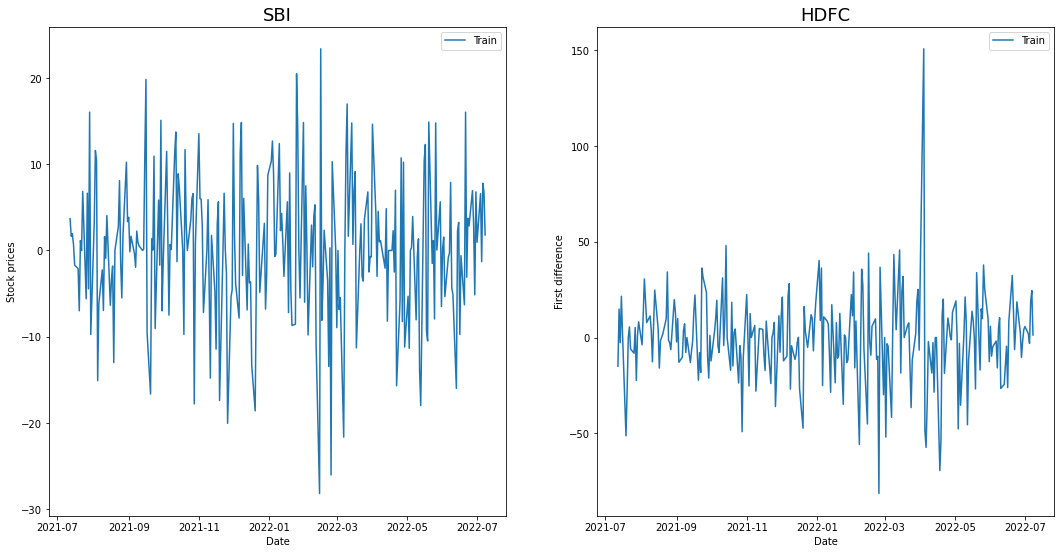

In [22]:
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.plot(first_diff, label ='Train')
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.title('SBI', fontsize = 18)

plt.subplot(1,2,2)
plt.plot(first_diff1, label ='Train')
plt.xlabel("Date")
plt.ylabel("First difference")
plt.legend()
plt.title('HDFC', fontsize = 18)

# Auto Regressive (AR) model

In [23]:
import statsmodels.tsa.stattools as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

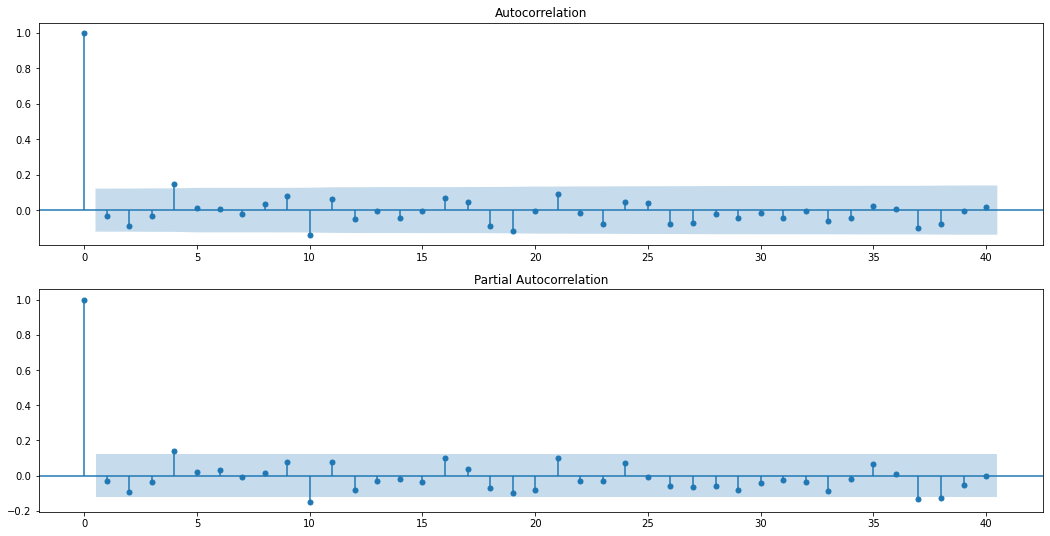

In [24]:
fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(211)
fig = plot_acf(first_diff.dropna(),lags = 40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(first_diff.dropna(),lags = 40, ax=ax2)

In [25]:
#Choosing p,d,q = 1

In [26]:
from statsmodels.tsa.ar_model import AutoReg

# fit model SBI data
model = AutoReg(train_sbi['Close'], lags=1)
model_fit = model.fit()
# make prediction
ar_sbi = model_fit.predict(234, 260)
print(ar_sbi)

2022-06-02    468.774401
2022-06-03    469.231995
2022-06-06    469.673368
2022-06-07    470.099093
2022-06-08    470.509727
2022-06-09    470.905803
2022-06-10    471.287837
2022-06-13    471.656328
2022-06-14    472.011756
2022-06-15    472.354584
2022-06-16    472.685258
2022-06-17    473.004210
2022-06-20    473.311854
2022-06-21    473.608593
2022-06-22    473.894811
2022-06-23    474.170883
2022-06-24    474.437168
2022-06-27    474.694013
2022-06-28    474.941753
2022-06-29    475.180710
2022-06-30    475.411196
2022-07-01    475.633511
2022-07-04    475.847944
2022-07-05    476.054776
2022-07-06    476.254275
2022-07-07    476.446703
2022-07-08    476.632308
Freq: B, dtype: float64


In [27]:
# fit model HDFC data
model = AutoReg(train_hdfc['Close'], lags=1)
model_fit = model.fit()
# make prediction
ar_hdfc = model_fit.predict(234, 260)
print(ar_hdfc)

2022-06-02    1397.775394
2022-06-03    1400.602810
2022-06-06    1403.335505
2022-06-07    1405.976654
2022-06-08    1408.529322
2022-06-09    1410.996475
2022-06-10    1413.380977
2022-06-13    1415.685596
2022-06-14    1417.913010
2022-06-15    1420.065804
2022-06-16    1422.146478
2022-06-17    1424.157448
2022-06-20    1426.101050
2022-06-21    1427.979540
2022-06-22    1429.795100
2022-06-23    1431.549837
2022-06-24    1433.245790
2022-06-27    1434.884927
2022-06-28    1436.469152
2022-06-29    1438.000305
2022-06-30    1439.480163
2022-07-01    1440.910446
2022-07-04    1442.292813
2022-07-05    1443.628870
2022-07-06    1444.920168
2022-07-07    1446.168207
2022-07-08    1447.374436
Freq: B, dtype: float64


In [28]:
ar_sbi.index = test_sbi.index
test_sbi.head()

,Close,Open
Date,,
2022-06-02,469.850006,466.899994
2022-06-03,464.500000,473.250000
2022-06-06,463.700012,464.200012
2022-06-07,463.399994,461.850006
2022-06-08,471.299988,466.600006


In [29]:
ar_hdfc.index = test_hdfc.index
test_hdfc.head()

,Close,Open
Date,,
2022-06-02,1385.099976,1387.250000
2022-06-03,1380.300049,1398.300049
2022-06-06,1378.449951,1376.300049
2022-06-07,1362.599976,1362.000000
2022-06-08,1367.400024,1373.300049


In [30]:
mse(ar_sbi, test_sbi['Close'])

315.28183566154

In [31]:
mse(ar_hdfc, test_hdfc['Close'])

7024.196765623646

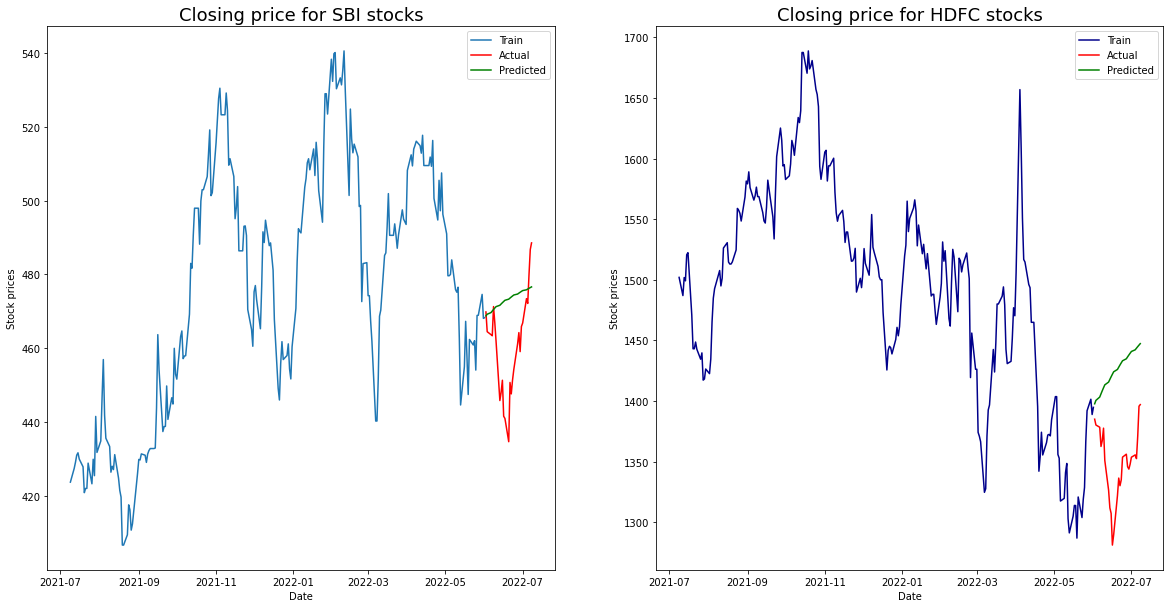

In [32]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(train_sbi['Close'], label ='Train')
plt.plot(test_sbi['Close'], label ='Actual',color='red')
plt.plot(ar_sbi, label ='Predicted',color='green')
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.title('Closing price for SBI stocks', fontsize = 18)

plt.subplot(1,2,2)
plt.plot(train_hdfc['Close'], label ='Train',color='darkblue')
plt.plot(test_hdfc['Close'], label ='Actual',color='red')
plt.plot(ar_hdfc, label ='Predicted',color='green')
plt.title('Closing price for HDFC stocks', fontsize = 18)
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.show()



# Moving Average (MA)

In [33]:
from statsmodels.tsa.arima.model import ARIMA

# fit model for SBI
model = ARIMA(train_sbi['Close'], order=(0,0,1))
model_fit = model.fit()
# make prediction
ma_sbi = model_fit.predict(234, 260)
print(ma_sbi)

2022-06-02    483.872882
2022-06-03    476.197085
2022-06-06    476.197085
2022-06-07    476.197085
2022-06-08    476.197085
2022-06-09    476.197085
2022-06-10    476.197085
2022-06-13    476.197085
2022-06-14    476.197085
2022-06-15    476.197085
2022-06-16    476.197085
2022-06-17    476.197085
2022-06-20    476.197085
2022-06-21    476.197085
2022-06-22    476.197085
2022-06-23    476.197085
2022-06-24    476.197085
2022-06-27    476.197085
2022-06-28    476.197085
2022-06-29    476.197085
2022-06-30    476.197085
2022-07-01    476.197085
2022-07-04    476.197085
2022-07-05    476.197085
2022-07-06    476.197085
2022-07-07    476.197085
2022-07-08    476.197085
Freq: B, Name: predicted_mean, dtype: float64


In [34]:
ma_sbi.index = test_sbi.index

mse(ma_sbi, test_sbi['Close'])

413.65496160645574

In [35]:
# fit model for HDFC
model = ARIMA(train_hdfc['Close'], order=(0,0,1))
model_fit = model.fit()
# make prediction
ma_hdfc = model_fit.predict(234, 260)
print(ma_hdfc)

2022-06-02    1468.141113
2022-06-03    1495.479501
2022-06-06    1495.479501
2022-06-07    1495.479501
2022-06-08    1495.479501
2022-06-09    1495.479501
2022-06-10    1495.479501
2022-06-13    1495.479501
2022-06-14    1495.479501
2022-06-15    1495.479501
2022-06-16    1495.479501
2022-06-17    1495.479501
2022-06-20    1495.479501
2022-06-21    1495.479501
2022-06-22    1495.479501
2022-06-23    1495.479501
2022-06-24    1495.479501
2022-06-27    1495.479501
2022-06-28    1495.479501
2022-06-29    1495.479501
2022-06-30    1495.479501
2022-07-01    1495.479501
2022-07-04    1495.479501
2022-07-05    1495.479501
2022-07-06    1495.479501
2022-07-07    1495.479501
2022-07-08    1495.479501
Freq: B, Name: predicted_mean, dtype: float64


In [36]:
ma_hdfc.index = test_hdfc.index

mse(ma_hdfc, test_hdfc['Close'])

22160.273476222304

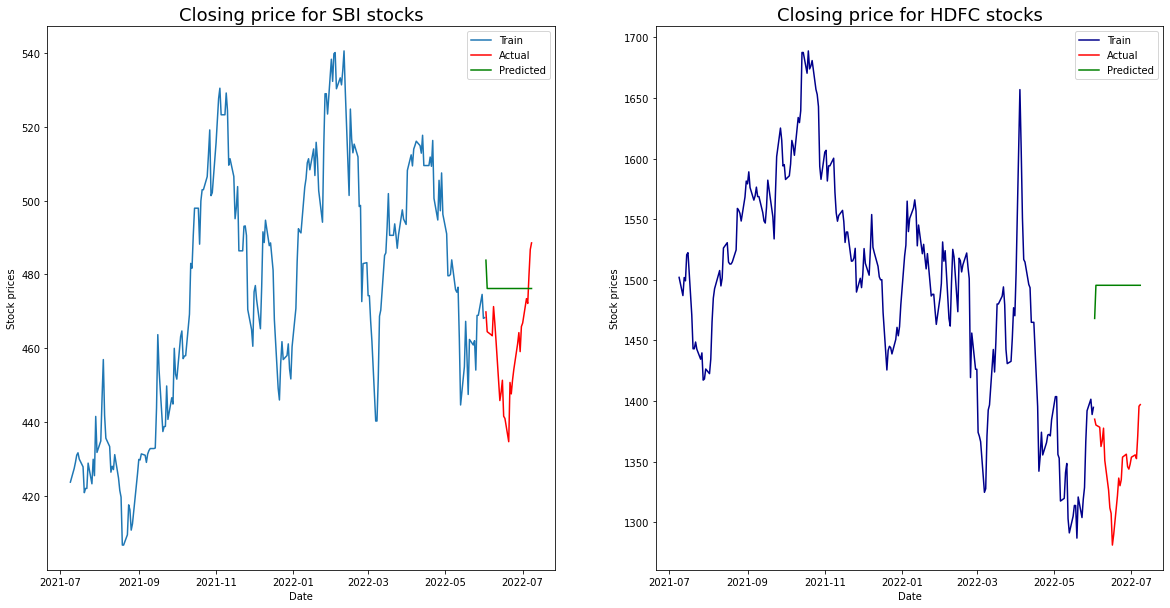

In [37]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(train_sbi['Close'], label ='Train')
plt.plot(test_sbi['Close'], label ='Actual', color = 'red')
plt.plot(ma_sbi, label ='Predicted', color= 'green')
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.title('Closing price for SBI stocks', fontsize = 18)

plt.subplot(1,2,2)
plt.plot(train_hdfc['Close'], label ='Train',color='darkblue')
plt.plot(test_hdfc['Close'], label ='Actual',color='red')
plt.plot(ma_hdfc, label ='Predicted',color='green')
plt.title('Closing price for HDFC stocks', fontsize = 18)
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.show()

# Simple Exponential Smoothing (SES)


In [38]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# fit model for SBI
model = SimpleExpSmoothing(train_sbi['Close'])
model_fit = model.fit()
# make prediction
ses_sbi = model_fit.predict(234, 260)
print(ses_sbi)

2022-06-02    468.300398
2022-06-03    468.300398
2022-06-06    468.300398
2022-06-07    468.300398
2022-06-08    468.300398
2022-06-09    468.300398
2022-06-10    468.300398
2022-06-13    468.300398
2022-06-14    468.300398
2022-06-15    468.300398
2022-06-16    468.300398
2022-06-17    468.300398
2022-06-20    468.300398
2022-06-21    468.300398
2022-06-22    468.300398
2022-06-23    468.300398
2022-06-24    468.300398
2022-06-27    468.300398
2022-06-28    468.300398
2022-06-29    468.300398
2022-06-30    468.300398
2022-07-01    468.300398
2022-07-04    468.300398
2022-07-05    468.300398
2022-07-06    468.300398
2022-07-07    468.300398
2022-07-08    468.300398
Freq: B, dtype: float64


In [39]:
# fit model for HDFC
model = SimpleExpSmoothing(train_hdfc['Close'])
model_fit = model.fit()
# make prediction
ses_hdfc = model_fit.predict(234, 260)
print(ses_hdfc)

2022-06-02    1394.849976
2022-06-03    1394.849976
2022-06-06    1394.849976
2022-06-07    1394.849976
2022-06-08    1394.849976
2022-06-09    1394.849976
2022-06-10    1394.849976
2022-06-13    1394.849976
2022-06-14    1394.849976
2022-06-15    1394.849976
2022-06-16    1394.849976
2022-06-17    1394.849976
2022-06-20    1394.849976
2022-06-21    1394.849976
2022-06-22    1394.849976
2022-06-23    1394.849976
2022-06-24    1394.849976
2022-06-27    1394.849976
2022-06-28    1394.849976
2022-06-29    1394.849976
2022-06-30    1394.849976
2022-07-01    1394.849976
2022-07-04    1394.849976
2022-07-05    1394.849976
2022-07-06    1394.849976
2022-07-07    1394.849976
2022-07-08    1394.849976
Freq: B, dtype: float64


In [40]:
ses_sbi.index = test_sbi.index
mse(ses_sbi, test_sbi['Close'])

229.8282600764612

In [41]:
ses_hdfc.index = test_hdfc.index
mse(ses_hdfc, test_hdfc['Close'])

2964.0788765693983

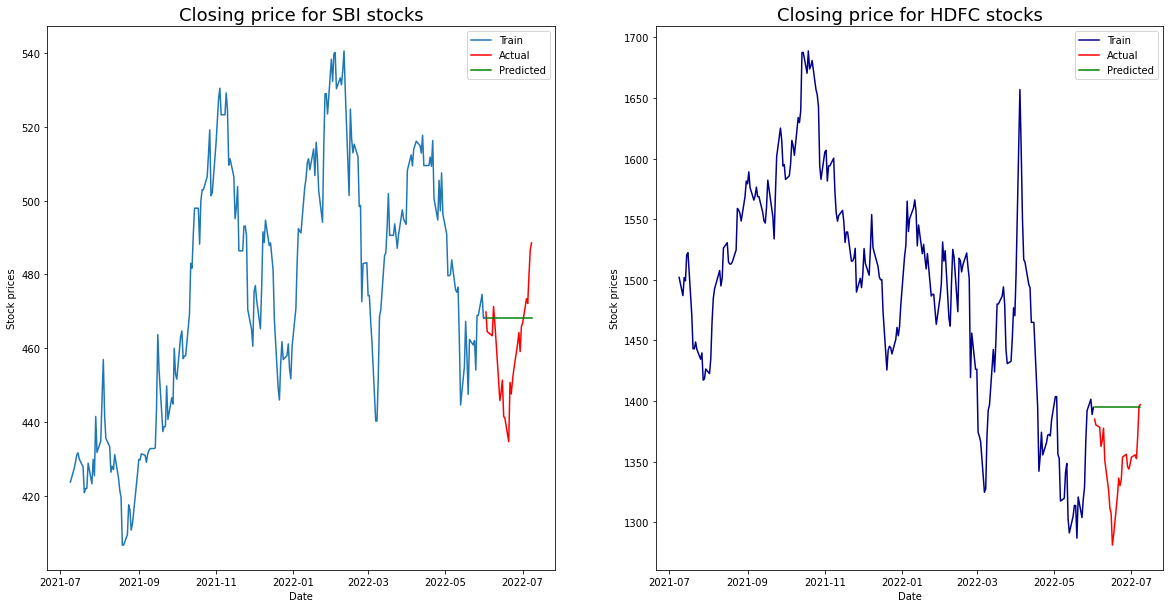

In [42]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(train_sbi['Close'], label ='Train')
plt.plot(test_sbi['Close'], label ='Actual', color = 'red')
plt.plot(ses_sbi, label ='Predicted', color= 'green')
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.title('Closing price for SBI stocks', fontsize = 18)

plt.subplot(1,2,2)
plt.plot(train_hdfc['Close'], label ='Train',color='darkblue')
plt.plot(test_hdfc['Close'], label ='Actual',color='red')
plt.plot(ses_hdfc, label ='Predicted',color='green')
plt.title('Closing price for HDFC stocks', fontsize = 18)
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.show()

# Autoregressive Integrated Moving Average (ARIMA)

# ARIMA(1,1,1)


In [43]:
# fit model for SBI
model = ARIMA(train_sbi['Close'], order=(1, 1, 1))
model_fit = model.fit()
# make prediction
arima_sbi = model_fit.predict(234, 260, typ='levels')
print(arima_sbi)

2022-06-02    468.358282
2022-06-03    468.382091
2022-06-06    468.391816
2022-06-07    468.395788
2022-06-08    468.397410
2022-06-09    468.398073
2022-06-10    468.398344
2022-06-13    468.398454
2022-06-14    468.398499
2022-06-15    468.398518
2022-06-16    468.398525
2022-06-17    468.398528
2022-06-20    468.398530
2022-06-21    468.398530
2022-06-22    468.398530
2022-06-23    468.398530
2022-06-24    468.398530
2022-06-27    468.398530
2022-06-28    468.398530
2022-06-29    468.398530
2022-06-30    468.398530
2022-07-01    468.398530
2022-07-04    468.398530
2022-07-05    468.398530
2022-07-06    468.398530
2022-07-07    468.398530
2022-07-08    468.398530
Freq: B, Name: predicted_mean, dtype: float64


In [44]:
# fit model for HDFC
model = ARIMA(train_hdfc['Close'], order=(1, 1, 1))
model_fit = model.fit()
# make prediction
arima_hdfc = model_fit.predict(234, 260, typ='levels')
print(arima_hdfc)

2022-06-02    1395.669638
2022-06-03    1395.410049
2022-06-06    1395.492261
2022-06-07    1395.466225
2022-06-08    1395.474470
2022-06-09    1395.471859
2022-06-10    1395.472686
2022-06-13    1395.472424
2022-06-14    1395.472507
2022-06-15    1395.472481
2022-06-16    1395.472489
2022-06-17    1395.472486
2022-06-20    1395.472487
2022-06-21    1395.472487
2022-06-22    1395.472487
2022-06-23    1395.472487
2022-06-24    1395.472487
2022-06-27    1395.472487
2022-06-28    1395.472487
2022-06-29    1395.472487
2022-06-30    1395.472487
2022-07-01    1395.472487
2022-07-04    1395.472487
2022-07-05    1395.472487
2022-07-06    1395.472487
2022-07-07    1395.472487
2022-07-08    1395.472487
Freq: B, Name: predicted_mean, dtype: float64


In [45]:
arima_sbi.index = test_sbi.index
mse(arima_sbi, test_sbi['Close'])

231.27161561235422

In [46]:
arima_hdfc.index = test_hdfc.index
mse(arima_hdfc, test_hdfc['Close'])

3021.8821289785924

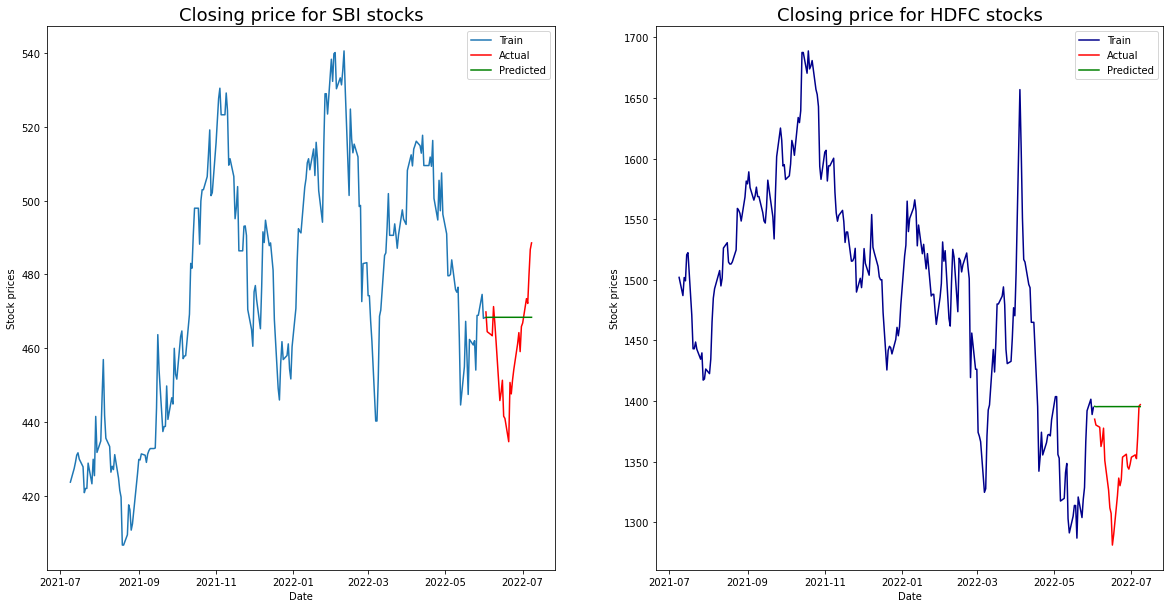

In [47]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(train_sbi['Close'], label ='Train')
plt.plot(test_sbi['Close'], label ='Actual', color = 'red')
plt.plot(arima_sbi, label ='Predicted', color= 'green')
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.title('Closing price for SBI stocks', fontsize = 18)

plt.subplot(1,2,2)
plt.plot(train_hdfc['Close'], label ='Train',color='darkblue')
plt.plot(test_hdfc['Close'], label ='Actual',color='red')
plt.plot(arima_hdfc, label ='Predicted',color='green')
plt.title('Closing price for HDFC stocks', fontsize = 18)
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.show()

# ARIMA (0,1,0)

In [48]:
# fit model for SBI
model = ARIMA(train_sbi['Close'], order=(0, 1, 0))
model_fit = model.fit()
# make prediction
arima_sbi = model_fit.predict(234, 260, typ='levels')
print(arima_sbi)

2022-06-02    468.299988
2022-06-03    468.299988
2022-06-06    468.299988
2022-06-07    468.299988
2022-06-08    468.299988
2022-06-09    468.299988
2022-06-10    468.299988
2022-06-13    468.299988
2022-06-14    468.299988
2022-06-15    468.299988
2022-06-16    468.299988
2022-06-17    468.299988
2022-06-20    468.299988
2022-06-21    468.299988
2022-06-22    468.299988
2022-06-23    468.299988
2022-06-24    468.299988
2022-06-27    468.299988
2022-06-28    468.299988
2022-06-29    468.299988
2022-06-30    468.299988
2022-07-01    468.299988
2022-07-04    468.299988
2022-07-05    468.299988
2022-07-06    468.299988
2022-07-07    468.299988
2022-07-08    468.299988
Freq: B, Name: predicted_mean, dtype: float64


In [49]:
# fit model for HDFC
model = ARIMA(train_hdfc['Close'], order=(0, 1, 0))
model_fit = model.fit()
# make prediction
arima_hdfc = model_fit.predict(234, 260, typ='levels')
print(arima_hdfc)

2022-06-02    1394.849976
2022-06-03    1394.849976
2022-06-06    1394.849976
2022-06-07    1394.849976
2022-06-08    1394.849976
2022-06-09    1394.849976
2022-06-10    1394.849976
2022-06-13    1394.849976
2022-06-14    1394.849976
2022-06-15    1394.849976
2022-06-16    1394.849976
2022-06-17    1394.849976
2022-06-20    1394.849976
2022-06-21    1394.849976
2022-06-22    1394.849976
2022-06-23    1394.849976
2022-06-24    1394.849976
2022-06-27    1394.849976
2022-06-28    1394.849976
2022-06-29    1394.849976
2022-06-30    1394.849976
2022-07-01    1394.849976
2022-07-04    1394.849976
2022-07-05    1394.849976
2022-07-06    1394.849976
2022-07-07    1394.849976
2022-07-08    1394.849976
Freq: B, Name: predicted_mean, dtype: float64


In [50]:
arima_sbi.index = test_sbi.index
mse(arima_sbi, test_sbi['Close'])

229.82224997804016

In [51]:
arima_hdfc.index = test_hdfc.index
mse(arima_hdfc, test_hdfc['Close'])

2964.0788846646155

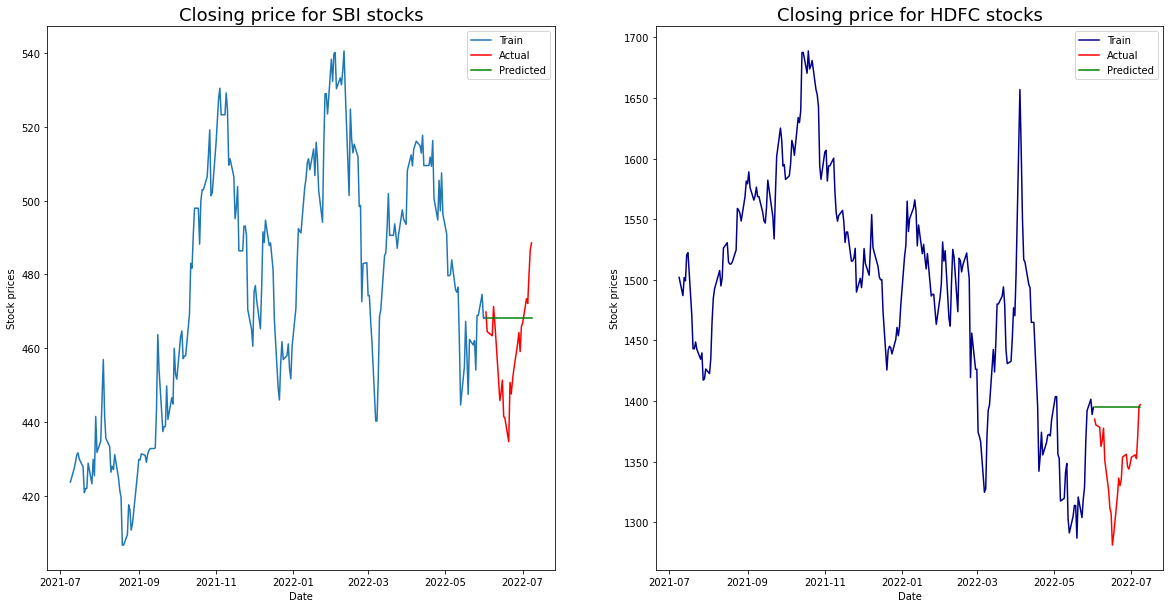

In [52]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(train_sbi['Close'], label ='Train')
plt.plot(test_sbi['Close'], label ='Actual', color = 'red')
plt.plot(arima_sbi, label ='Predicted', color= 'green')
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.title('Closing price for SBI stocks', fontsize = 18)

plt.subplot(1,2,2)
plt.plot(train_hdfc['Close'], label ='Train',color='darkblue')
plt.plot(test_hdfc['Close'], label ='Actual',color='red')
plt.plot(arima_hdfc, label ='Predicted',color='green')
plt.title('Closing price for HDFC stocks', fontsize = 18)
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.show()

# ARIMA (2,1,2)

In [53]:
# fit model for SBI
model = ARIMA(train_sbi['Close'], order=(2, 1, 2))
model_fit = model.fit()
# make prediction
arima_sbi = model_fit.predict(234, 260, typ='levels')
print(arima_sbi)

2022-06-02    471.000811
2022-06-03    470.599858
2022-06-06    467.895892
2022-06-07    468.274030
2022-06-08    470.980945
2022-06-09    470.625647
2022-06-10    467.915974
2022-06-13    468.248412
2022-06-14    470.960650
2022-06-15    470.651091
2022-06-16    467.936482
2022-06-17    468.223143
2022-06-20    470.939931
2022-06-21    470.676183
2022-06-22    467.957411
2022-06-23    468.198230
2022-06-24    470.918794
2022-06-27    470.700916
2022-06-28    467.978754
2022-06-29    468.173678
2022-06-30    470.897246
2022-07-01    470.725284
2022-07-04    468.000506
2022-07-05    468.149496
2022-07-06    470.875292
2022-07-07    470.749279
2022-07-08    468.022659
Freq: B, Name: predicted_mean, dtype: float64


C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
# fit model for HDFC
model = ARIMA(train_hdfc['Close'], order=(2, 1, 2))
model_fit = model.fit()
# make prediction
arima_hdfc = model_fit.predict(234, 260, typ='levels')
print(arima_hdfc)

2022-06-02    1402.388664
2022-06-03    1397.604199
2022-06-06    1389.328394
2022-06-07    1392.516895
2022-06-08    1401.225379
2022-06-09    1399.683043
2022-06-10    1390.849990
2022-06-13    1390.753079
2022-06-14    1399.409398
2022-06-15    1401.083796
2022-06-16    1392.888821
2022-06-17    1389.749507
2022-06-20    1397.224191
2022-06-21    1401.670635
2022-06-22    1395.141740
2022-06-23    1389.584251
2022-06-24    1394.981690
2022-06-27    1401.423800
2022-06-28    1397.298829
2022-06-29    1390.220173
2022-06-30    1392.979459
2022-07-01    1400.434047
2022-07-04    1399.084440
2022-07-05    1391.517865
2022-07-06    1391.462748
2022-07-07    1398.883018
2022-07-08    1400.290874
Freq: B, Name: predicted_mean, dtype: float64


In [55]:
arima_sbi.index = test_sbi.index
mse(arima_sbi, test_sbi['Close'])

247.28092185403034

In [56]:
arima_hdfc.index = test_hdfc.index
mse(arima_hdfc, test_hdfc['Close'])

3014.689039058795

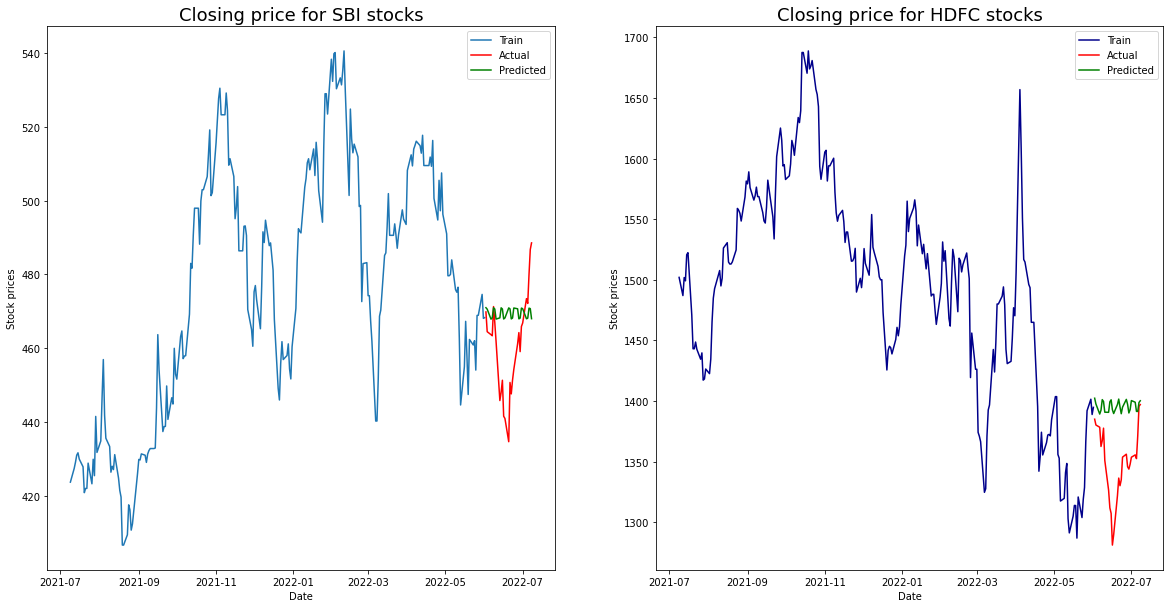

In [57]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(train_sbi['Close'], label ='Train')
plt.plot(test_sbi['Close'], label ='Actual', color = 'red')
plt.plot(arima_sbi, label ='Predicted', color= 'green')
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.title('Closing price for SBI stocks', fontsize = 18)

plt.subplot(1,2,2)
plt.plot(train_hdfc['Close'], label ='Train',color='darkblue')
plt.plot(test_hdfc['Close'], label ='Actual',color='red')
plt.plot(arima_hdfc, label ='Predicted',color='green')
plt.title('Closing price for HDFC stocks', fontsize = 18)
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.show()

# ARIMA (3,1,3)


In [91]:
# fit model for SBI
model = ARIMA(train_sbi['Close'], order=(3, 1, 3))
model_fit = model.fit()
# make prediction
arima_sbi = model_fit.predict(234, 260, typ='levels')
print(arima_sbi)

2022-06-02    466.336891
2022-06-03    468.183577
2022-06-06    467.477600
2022-06-07    467.185353
2022-06-08    468.055138
2022-06-09    467.099320
2022-06-10    467.776699
2022-06-13    467.527476
2022-06-14    467.397663
2022-06-15    467.739485
2022-06-16    467.373984
2022-06-17    467.626738
2022-06-20    467.539764
2022-06-21    467.483335
2022-06-22    467.617395
2022-06-23    467.477800
2022-06-24    467.571948
2022-06-27    467.541898
2022-06-28    467.517763
2022-06-29    467.570239
2022-06-30    467.516988
2022-07-01    467.551993
2022-07-04    467.541737
2022-07-05    467.531547
2022-07-06    467.552050
2022-07-07    467.531761
2022-07-08    467.544752
Freq: B, Name: predicted_mean, dtype: float64


C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [59]:
# fit model for HDFC
model = ARIMA(train_hdfc['Close'], order=(3, 1, 3))
model_fit = model.fit()
# make prediction
arima_hdfc = model_fit.predict(234, 260, typ='levels')
print(arima_hdfc)

2022-06-02    1403.873768
2022-06-03    1397.529995
2022-06-06    1390.911081
2022-06-07    1392.779186
2022-06-08    1402.542077
2022-06-09    1399.777638
2022-06-10    1392.204139
2022-06-13    1391.202327
2022-06-14    1400.619545
2022-06-15    1401.313713
2022-06-16    1394.057616
2022-06-17    1390.324093
2022-06-20    1398.369154
2022-06-21    1402.016102
2022-06-22    1396.162427
2022-06-23    1390.234507
2022-06-24    1396.086156
2022-06-27    1401.873149
2022-06-28    1398.205393
2022-06-29    1390.907512
2022-06-30    1394.055034
2022-07-01    1400.979261
2022-07-04    1399.908764
2022-07-05    1392.214283
2022-07-06    1392.511462
2022-07-07    1399.516445
2022-07-08    1401.062769
Freq: B, Name: predicted_mean, dtype: float64


C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [60]:
arima_sbi.index = test_sbi.index
mse(arima_sbi, test_sbi['Close'])

219.39904796443147

In [61]:
arima_hdfc.index = test_hdfc.index
mse(arima_hdfc, test_hdfc['Close'])

3090.361633372302

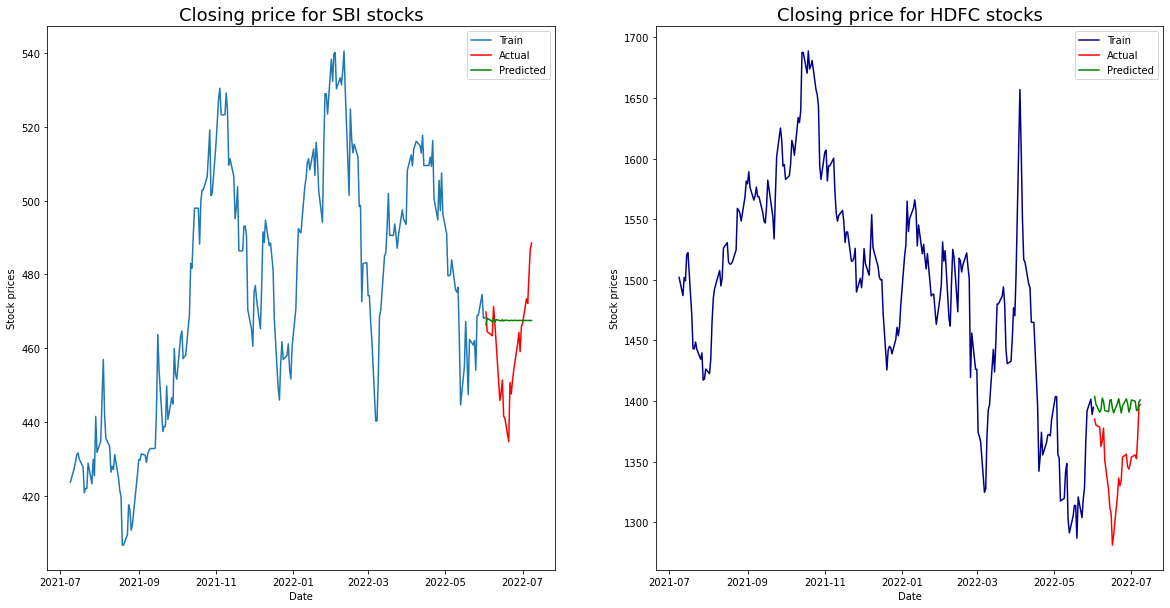

In [62]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(train_sbi['Close'], label ='Train')
plt.plot(test_sbi['Close'], label ='Actual', color = 'red')
plt.plot(arima_sbi, label ='Predicted', color= 'green')
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.title('Closing price for SBI stocks', fontsize = 18)

plt.subplot(1,2,2)
plt.plot(train_hdfc['Close'], label ='Train',color='darkblue')
plt.plot(test_hdfc['Close'], label ='Actual',color='red')
plt.plot(arima_hdfc, label ='Predicted',color='green')
plt.title('Closing price for HDFC stocks', fontsize = 18)
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.show()

In [63]:
from pmdarima import auto_arima

model_auto = auto_arima(train_sbi['Close'],exog=train_sbi['Open'],
                        m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -827.470
Date:                Sat, 09 Jul 2022   AIC                           1656.940
Time:                        15:18:19   BIC                           1660.391
Sample:                             0   HQIC                          1658.332
                                - 234                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        71.1556      5.891     12.079      0.000      59.610      82.702
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 4.71
Prob(Q):                              0.68   Prob(JB):                         0.09
Heteroskedasticity (H):               1.73   Skew:                            -0.23
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
from pmdarima import auto_arima

model_auto = auto_arima(train_hdfc['Close'],exog=train_hdfc['Open'],
                        m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1067.662
Date:                Sat, 09 Jul 2022   AIC                           2137.324
Time:                        15:18:21   BIC                           2140.775
Sample:                             0   HQIC                          2138.715
                                - 234                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       559.2604     24.549     22.782      0.000     511.146     607.375
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):               485.87
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               3.78   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [116]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model for SBI
model = SARIMAX(train_sbi['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)
# make prediction
sarima_sbi = model_fit.predict(234, 260)
print(sarima_sbi)

2022-06-02    470.233671
2022-06-03    468.564906
2022-06-06    466.422320
2022-06-07    466.855413
2022-06-08    471.583204
2022-06-09    472.649769
2022-06-10    472.159104
2022-06-13    474.211715
2022-06-14    475.369424
2022-06-15    470.381993
2022-06-16    468.797435
2022-06-17    469.452282
2022-06-20    472.387240
2022-06-21    469.959138
2022-06-22    466.990064
2022-06-23    468.849956
2022-06-24    472.963116
2022-06-27    474.037862
2022-06-28    472.811214
2022-06-29    476.121532
2022-06-30    477.169950
2022-07-01    473.232053
2022-07-04    471.162516
2022-07-05    471.772484
2022-07-06    474.608652
2022-07-07    472.255470
2022-07-08    469.367941
Freq: B, Name: predicted_mean, dtype: float64


In [117]:
# fit model for HDFC
model = SARIMAX(train_hdfc['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)
# make prediction
sarima_hdfc = model_fit.predict(234, 260)
print(sarima_hdfc)

2022-06-02    1399.754040
2022-06-03    1397.084755
2022-06-06    1397.784881
2022-06-07    1396.923418
2022-06-08    1394.485288
2022-06-09    1401.133399
2022-06-10    1397.637898
2022-06-13    1398.402912
2022-06-14    1402.499678
2022-06-15    1397.544052
2022-06-16    1390.118943
2022-06-17    1392.312410
2022-06-20    1396.647774
2022-06-21    1394.035412
2022-06-22    1395.371192
2022-06-23    1393.677408
2022-06-24    1391.587997
2022-06-27    1398.036005
2022-06-28    1394.217937
2022-06-29    1394.085755
2022-06-30    1397.669006
2022-07-01    1392.364116
2022-07-04    1385.064040
2022-07-05    1387.167952
2022-07-06    1391.489576
2022-07-07    1388.878589
2022-07-08    1390.229727
Freq: B, Name: predicted_mean, dtype: float64


In [118]:
sarima_sbi.index = test_sbi.index
mse(sarima_sbi, test_sbi['Close'])

287.4032908486906

In [119]:
sarima_hdfc.index = test_hdfc.index
mse(sarima_hdfc, test_hdfc['Close'])

2977.2660775410336

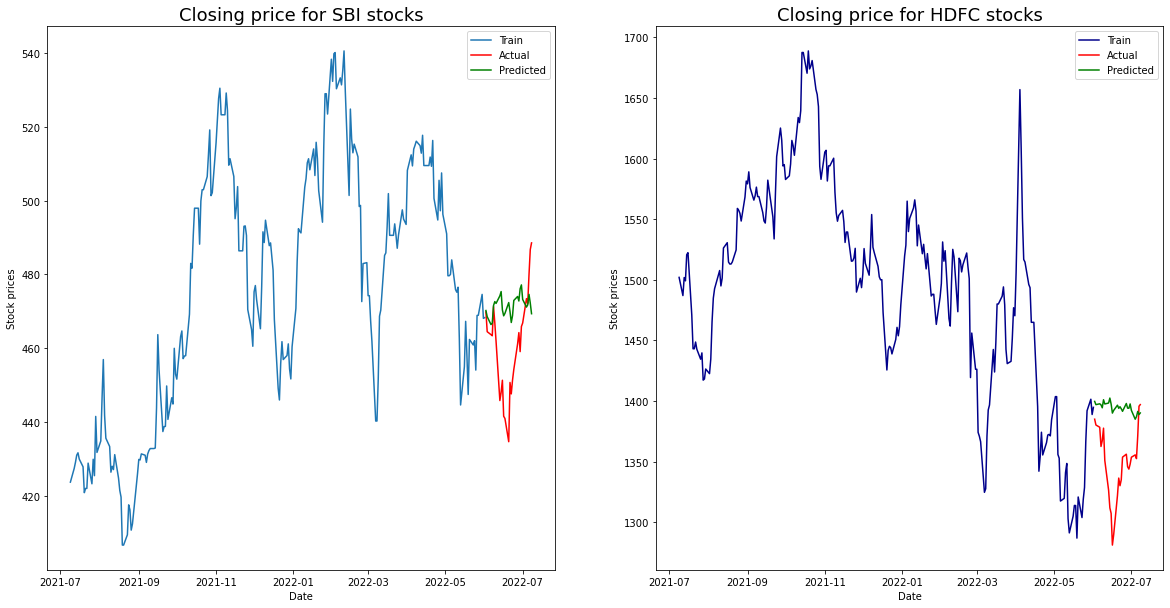

In [120]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(train_sbi['Close'], label ='Train')
plt.plot(test_sbi['Close'], label ='Actual', color = 'red')
plt.plot(sarima_sbi, label ='Predicted', color= 'green')
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.title('Closing price for SBI stocks', fontsize = 18)

plt.subplot(1,2,2)
plt.plot(train_hdfc['Close'], label ='Train',color='darkblue')
plt.plot(test_hdfc['Close'], label ='Actual',color='red')
plt.plot(sarima_hdfc, label ='Predicted',color='green')
plt.title('Closing price for HDFC stocks', fontsize = 18)
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.show()

In [121]:
from pandas.tseries.offsets import DateOffset
future_dates = [sbi.index[-1]+ DateOffset(days=x) for x in range(0,60)]

In [122]:
future_datest_sbi = pd.DataFrame(index = future_dates[1:],columns = sbi.columns)

In [123]:
future_datest_sbi.tail()

,Close,Open,First difference
2022-09-01,NaN,NaN,NaN
2022-09-02,NaN,NaN,NaN
2022-09-03,NaN,NaN,NaN
2022-09-04,NaN,NaN,NaN
2022-09-05,NaN,NaN,NaN


In [124]:
future_sbi = pd.concat([sbi,future_datest_sbi])
future_sbi

,Close,Open,First difference
2021-07-09,423.750000,425.000000,NaN
2021-07-12,427.450012,426.500000,3.700012
2021-07-13,429.100006,430.000000,1.649994
2021-07-14,431.049988,429.000000,1.949982
2021-07-15,431.700012,432.700012,0.650024
2021-07-16,430.000000,432.000000,-1.700012
2021-07-19,427.899994,423.399994,-2.100006
2021-07-20,420.899994,427.000000,-7.000000
2021-07-21,422.049988,425.549988,1.149994
2021-07-22,422.049988,425.549988,0.000000


In [125]:
future_sbi.forecast = future_sbi['forecast'].fillna(value= future_sbi.mean())
future_sbi['forecast'] = model_fit.predict(start = 259, end = 290, dynamic= True)  
future_sbi[['Close', 'forecast']].plot(figsize=(12, 8))

KeyError: 'forecast'

In [126]:
from pandas.tseries.offsets import DateOffset
future_dates = [hdfc.index[-1]+ DateOffset(days=x) for x in range(0,60)]

In [127]:
future_datest_hdfc = pd.DataFrame(index = future_dates[1:],columns = hdfc.columns)

In [128]:
future_datest_hdfc.tail()

,Close,Open,First difference
2022-09-01,NaN,NaN,NaN
2022-09-02,NaN,NaN,NaN
2022-09-03,NaN,NaN,NaN
2022-09-04,NaN,NaN,NaN
2022-09-05,NaN,NaN,NaN


In [129]:
future_hdfc = pd.concat([hdfc,future_datest_hdfc])
future_hdfc

,Close,Open,First difference
2021-07-09,1502.000000,1512.550049,NaN
2021-07-12,1487.000000,1502.000000,-15.000000
2021-07-13,1501.849976,1496.099976,14.849976
2021-07-14,1499.150024,1497.500000,-2.699952
2021-07-15,1520.699951,1505.000000,21.549927
2021-07-16,1522.349976,1527.949951,1.650025
2021-07-19,1471.000000,1487.000000,-51.349976
2021-07-20,1443.150024,1442.000000,-27.849976
2021-07-21,1443.150024,1442.000000,0.000000
2021-07-22,1448.699951,1456.099976,5.549927


In [130]:
future_hdfc.forecast = future_hdfc['forecast'].fillna(value= future_hdfc.mean())
future_hdfc['forecast'] = model_fit.predict(start = 259, end = 320, dynamic= True)  
future_hdfc[['Close', 'forecast']].plot(figsize=(12, 8))

KeyError: 'forecast'

# Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)

In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model for SBI
model = SARIMAX(train_sbi['Close'], exog=train_sbi['Open'], order=(1, 1, 1), seasonal_order=(1,1,1,4))
model_fit = model.fit(disp=False)

# make prediction

sarimax_sbi = model_fit.predict(234, 260, exog = test_sbi['Open'])
print(sarimax_sbi)

2022-06-02    468.786421
2022-06-03    470.908631
2022-06-06    464.085387
2022-06-07    464.822345
2022-06-08    469.322312
2022-06-09    468.028841
2022-06-10    463.288677
2022-06-13    460.416877
2022-06-14    456.806849
2022-06-15    456.312686
2022-06-16    459.527468
2022-06-17    452.361354
2022-06-20    455.016115
2022-06-21    450.955703
2022-06-22    456.005249
2022-06-23    458.004977
2022-06-24    463.817799
2022-06-27    463.416550
2022-06-28    462.334809
2022-06-29    464.839945
2022-06-30    466.007862
2022-07-01    465.725206
2022-07-04    467.353563
2022-07-05    474.146419
2022-07-06    475.909909
2022-07-07    478.307083
2022-07-08    480.828802
Freq: B, Name: predicted_mean, dtype: float64


In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model for SBI
model = SARIMAX(train_hdfc['Close'], exog=train_hdfc['Open'], order=(1, 1, 1), seasonal_order=(1,1,1,4))
model_fit = model.fit(disp=False)

# make prediction

sarimax_hdfc = model_fit.predict(234, 260, exog = test_hdfc['Open'])
print(sarimax_hdfc)

2022-06-02    1393.479825
2022-06-03    1397.036493
2022-06-06    1376.152817
2022-06-07    1366.175354
2022-06-08    1377.619840
2022-06-09    1363.789081
2022-06-10    1361.393564
2022-06-13    1329.145339
2022-06-14    1319.498660
2022-06-15    1307.317566
2022-06-16    1314.679492
2022-06-17    1283.665371
2022-06-20    1313.159137
2022-06-21    1339.831263
2022-06-22    1335.119222
2022-06-23    1334.972498
2022-06-24    1344.365876
2022-06-27    1370.344098
2022-06-28    1345.802165
2022-06-29    1335.437122
2022-06-30    1341.766185
2022-07-01    1345.917789
2022-07-04    1354.580596
2022-07-05    1365.624383
2022-07-06    1352.680843
2022-07-07    1379.170249
2022-07-08    1406.641333
Freq: B, Name: predicted_mean, dtype: float64


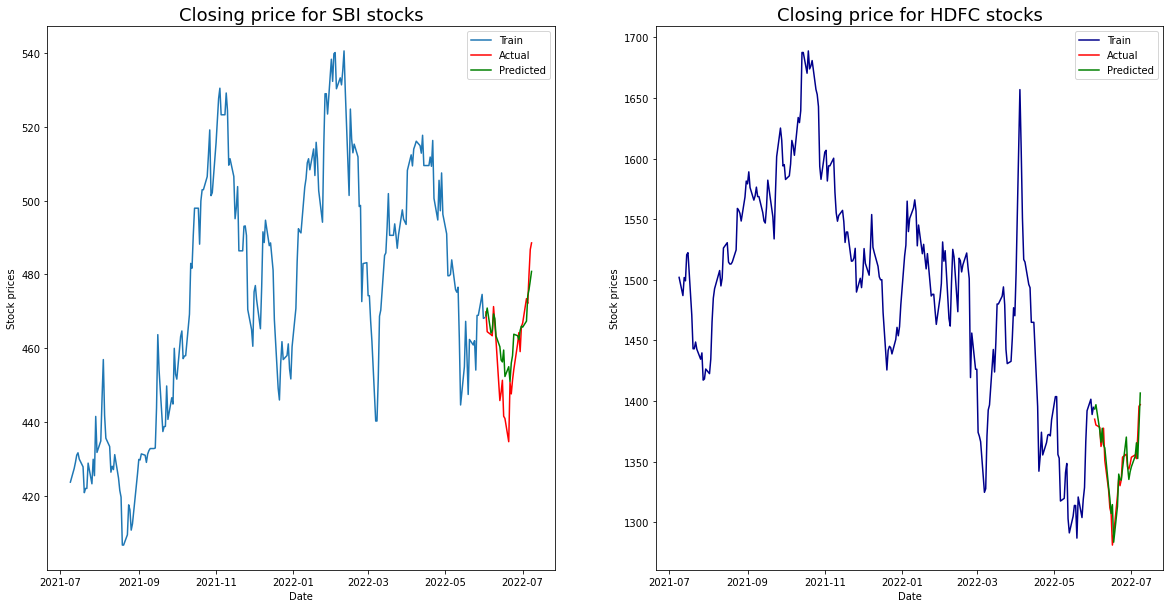

In [72]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(train_sbi['Close'], label ='Train')
plt.plot(test_sbi['Close'], label ='Actual', color = 'red')
plt.plot(sarimax_sbi, label ='Predicted', color= 'green')
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.title('Closing price for SBI stocks', fontsize = 18)

plt.subplot(1,2,2)
plt.plot(train_hdfc['Close'], label ='Train',color='darkblue')
plt.plot(test_hdfc['Close'], label ='Actual',color='red')
plt.plot(sarimax_hdfc, label ='Predicted',color='green')
plt.title('Closing price for HDFC stocks', fontsize = 18)
plt.xlabel("Date")
plt.ylabel("Stock prices")
plt.legend()
plt.show()